In [1]:
from nlp_functions import *
import os
import itertools
import string
import tensorflow_hub as hub
import tensorflow as tf
from keras import backend as K
import keras.layers as layers
from keras.models import Model, load_model
from keras.layers import Layer
from keras.utils import Sequence
from keras.layers import Activation, Conv1D, Dense, Dropout, Embedding, Flatten, GlobalMaxPool1D, LSTM
from keras.layers import Input, MaxPooling1D, GlobalAveragePooling1D, multiply, concatenate, Reshape
from keras.layers import Bidirectional
from keras.optimizers import Adam
import keras.initializers as initializers
import keras.regularizers as regularizers
import keras.constraints as constraints
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.utils import shuffle
import pickle

sess = tf.Session()

Using TensorFlow backend.


In [2]:
plt.style.use('seaborn')

In [3]:
bert_path = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"
elmo_path = "https://tfhub.dev/google/elmo/2"

# Load data

In [4]:
# Importing our data
sentiment140 = read_sentiment_file(DATA_DIRECTORY, 'sentiment140_train.csv')

In [5]:
# Sampling 10% the data
sentiment140 = sentiment140.sample(frac=0.5, random_state=7)

In [6]:
# Separating into characteristics and labels
X = sentiment140['text']
y = sentiment140['polarity']

In [7]:
# Cleaning the texts and mapping for easy classification
X = clean_data(X)
y = y.map({0: int(0), 4: int(1)})

In [8]:
# Calculate maximum sequence length
max_seq_length = max(X.str.len())

In [9]:
# Split the data to train and test, then train and val
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=7)

# ELMO pipeline

## Elmo Tokenizer

In [10]:
from elmo_tokenizer import ELMO_tokenizer

In [11]:
tokenizer = ELMO_tokenizer(max_seq_length)

In [12]:
train_tokens = tokenizer.predict(X_train.tolist())
train_label = y_train.tolist()

val_tokens = tokenizer.predict(X_val.tolist())
val_label = y_val.tolist()

test_tokens = tokenizer.predict(X_test.tolist())
test_label = y_test.tolist()

Converting examples to tokens:   0%|          | 0/512000 [00:00<?, ?it/s]

Converting examples to tokens:   0%|          | 0/128000 [00:00<?, ?it/s]

Converting examples to tokens:   0%|          | 0/160000 [00:00<?, ?it/s]

## Elmo Model

In [13]:
from elmo_layer import ElmoLayer

Instructions for updating:
non-resource variables are not supported in the long term


In [14]:
from keras.layers import Flatten, Masking
def build_model_elmo(max_seq_length): 
    input_tokens = Input(shape=(max_seq_length,), dtype="string")
    elmo_output = ElmoLayer(trainable=True, tf_hub=elmo_path, output_representation='default')(input_tokens)
    dense = Dense(256, activation='relu')(elmo_output)
    pred = Dense(1, activation='sigmoid')(dense)
    model = Model(inputs=input_tokens, outputs=pred)
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy', metrics.Precision(name='precision'), metrics.Recall(name='recall')])
    model.summary()
    return model
def initialize_vars(sess):
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    K.set_session(sess)

In [15]:
elmo_model = build_model_elmo(max_seq_length)
initialize_vars(sess)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 138)               0         
_________________________________________________________________
elmo_layer_1 (ElmoLayer)     (None, 1024)              93600852  
_________________________________________________________________
dense_1 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 93,863,509
Trainable params: 262,661
Non-trainable params: 93,600,848
_________________________________________________________________


In [16]:
"""from keras.utils import plot_model
plot_model(
    elmo_model,
    to_file='../figures/elmo-arc.png',
    show_shapes=True,
    rankdir='TB',
    dpi=300);"""

"from keras.utils import plot_model\nplot_model(\n    elmo_model,\n    to_file='../figures/elmo-arc.png',\n    show_shapes=True,\n    rankdir='TB',\n    dpi=300);"

In [17]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True)
history_elmo = elmo_model.fit(
    train_tokens,
    train_label,
    validation_data=(val_tokens, val_label),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping]
)

Train on 512000 samples, validate on 128000 samples
Epoch 1/20
512000/512000 [==============================] - 10159s 20ms/step - loss: 0.4595 - accuracy: 0.7816 - precision: 0.7858 - recall: 0.7741 - val_loss: 0.4375 - val_accuracy: 0.7960 - val_precision: 0.7876 - val_recall: 0.8108
Epoch 2/20
512000/512000 [==============================] - 10286s 20ms/step - loss: 0.4294 - accuracy: 0.8002 - precision: 0.8041 - recall: 0.7936 - val_loss: 0.4253 - val_accuracy: 0.8026 - val_precision: 0.7994 - val_recall: 0.8080
Epoch 3/20
512000/512000 [==============================] - 10289s 20ms/step - loss: 0.4142 - accuracy: 0.8087 - precision: 0.8123 - recall: 0.8028 - val_loss: 0.4298 - val_accuracy: 0.8000 - val_precision: 0.8379 - val_recall: 0.7441
Epoch 4/20
512000/512000 [==============================] - 10295s 20ms/step - loss: 0.4008 - accuracy: 0.8162 - precision: 0.8201 - recall: 0.8099 - val_loss: 0.4232 - val_accuracy: 0.8054 - val_precision: 0.8198 - val_recall: 0.7829
Epoch 5/

In [18]:
metrics_elmo = pd.DataFrame(history_elmo.history)
metrics_elmo

,val_loss,val_accuracy,val_precision,val_recall,loss,accuracy,precision,recall
0,0.437520,0.796031,0.787628,0.810831,0.459489,0.781631,0.785827,0.774063
1,0.425300,0.802562,0.799394,0.808035,0.429394,0.800209,0.804108,0.793598
2,0.429827,0.799992,0.837850,0.744135,0.414164,0.808742,0.812344,0.802789
3,0.423183,0.805352,0.819810,0.782918,0.400782,0.816150,0.820052,0.809877
4,0.422357,0.804453,0.809284,0.796820,0.388772,0.822781,0.826713,0.816595
5,0.424602,0.804578,0.801686,0.809550,0.377332,0.828898,0.832924,0.822691
6,0.428698,0.804969,0.800372,0.812799,0.366176,0.834900,0.839383,0.828142
7,0.445718,0.799641,0.788993,0.818250,0.355726,0.840375,0.844460,0.834297
8,0.449182,0.800469,0.786495,0.825045,0.345646,0.845389,0.849472,0.839404
9,0.455405,0.796094,0.787820,0.810659,0.336406,0.850256,0.854259,0.844468


In [19]:
print(f'Best training loss: {metrics_elmo.sort_values(by="val_loss", ascending=True).iloc[0,4]}')
print(f'Best training accuracy: {metrics_elmo.sort_values(by="val_loss", ascending=True).iloc[0,5]}')
print(f'Best training precision: {metrics_elmo.sort_values(by="val_loss", ascending=True).iloc[0,6]}')
print(f'Best training recall: {metrics_elmo.sort_values(by="val_loss", ascending=True).iloc[0,7]}')
print('---------------------------------------------')
print(f'Best validation loss: {metrics_elmo.sort_values(by="val_loss", ascending=True).iloc[0,0]}')
print(f'Best validation accuracy: {metrics_elmo.sort_values(by="val_loss", ascending=True).iloc[0,1]}')
print(f'Best validation precision: {metrics_elmo.sort_values(by="val_loss", ascending=True).iloc[0,2]}')
print(f'Best validation recall: {metrics_elmo.sort_values(by="val_loss", ascending=True).iloc[0,3]}')

Best training loss: 0.3887719880156219
Best training accuracy: 0.8227812647819519
Best training precision: 0.8267127275466919
Best training recall: 0.8165945410728455
---------------------------------------------
Best validation loss: 0.4223570044189692
Best validation accuracy: 0.8044531345367432
Best validation precision: 0.8092835545539856
Best validation recall: 0.7968198657035828


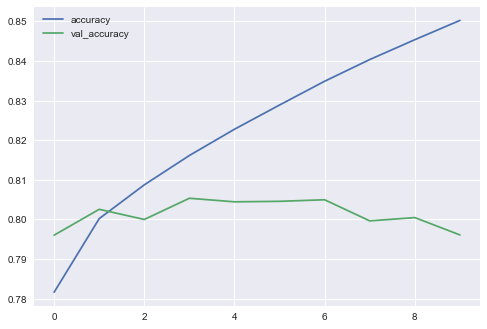

In [20]:
metrics_elmo[['accuracy','val_accuracy']].plot()
plt.savefig('../figures/elmo_50_acc.jpg', dpi=300)

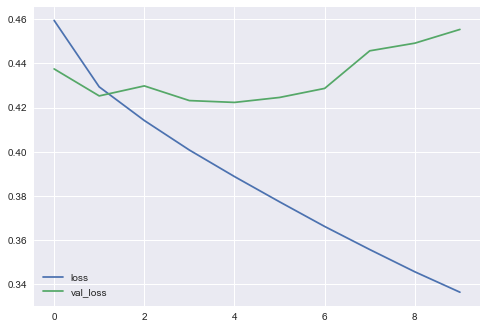

In [21]:
metrics_elmo[['loss','val_loss']].plot()
plt.savefig('../figures/elmo_50_loss.jpg', dpi=300)

In [22]:
# Loss metrics for the trained model
test_loss, test_accuracy, test_precision, test_recall = elmo_model.evaluate(test_tokens, test_label)

160000/160000 [==============================] - 2549s 16ms/step


In [23]:
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')
print(f'Test precision: {test_precision}')
print(f'Test recall: {test_recall}')

Test loss: 0.4282321566492319
Test accuracy: 0.8021249771118164
Test precision: 0.8055311441421509
Test recall: 0.7939754128456116


In [24]:
elmo_model.save('../models/elmo_model_50.h5')

# BERT pipeline

## Bert tokenizer

In [25]:
# Create datasets (Only take up to max_seq_length words for memory)
train_text = X_train.tolist()
train_text = [' '.join(t.split()[0:max_seq_length]) for t in train_text]
train_text = np.array(train_text, dtype=object)[:, np.newaxis]
train_label = y_train.tolist()

val_text = X_val.tolist()
val_text = [' '.join(t.split()[0:max_seq_length]) for t in val_text]
val_text = np.array(val_text, dtype=object)[:, np.newaxis]
val_label = y_val.tolist()

test_text = X_test.tolist()
test_text = [' '.join(t.split()[0:max_seq_length]) for t in test_text]
test_text = np.array(test_text, dtype=object)[:, np.newaxis]
test_label = y_test.tolist()

In [26]:
from bert_tokenizer import BERT_tokenizer

In [27]:
tokenizer = BERT_tokenizer(bert_path, max_seq_length)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [28]:
(train_input_ids, train_input_masks, train_segment_ids, train_labels) = tokenizer.predict(train_text, train_label)
(val_input_ids, val_input_masks, val_segment_ids, val_labels) = tokenizer.predict(val_text, val_label)
(test_input_ids, test_input_masks, test_segment_ids, test_labels) = tokenizer.predict(test_text, test_label)


Converting examples to features:   0%|          | 0/512000 [00:00<?, ?it/s]

INFO:tensorflow:Writing example 0 of 512000


INFO:tensorflow:Writing example 0 of 512000


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:Tokens True: [CLS] i need a good mac twitter desktop client lets here your best suggestions [SEP]


INFO:tensorflow:Tokens True: [CLS] i need a good mac twitter desktop client lets here your best suggestions [SEP]


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] i need a good mac twitter desktop client lets here your best suggestions [SEP]


INFO:tensorflow:tokens: [CLS] i need a good mac twitter desktop client lets here your best suggestions [SEP]


INFO:tensorflow:input_ids: 101 1045 2342 1037 2204 6097 10474 15363 7396 11082 2182 2115 2190 15690 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1045 2342 1037 2204 6097 10474 15363 7396 11082 2182 2115 2190 15690 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:Writing example 10000 of 512000


INFO:tensorflow:Writing example 10000 of 512000


INFO:tensorflow:Writing example 20000 of 512000


INFO:tensorflow:Writing example 20000 of 512000


INFO:tensorflow:Writing example 30000 of 512000


INFO:tensorflow:Writing example 30000 of 512000


INFO:tensorflow:Writing example 40000 of 512000


INFO:tensorflow:Writing example 40000 of 512000


INFO:tensorflow:Writing example 50000 of 512000


INFO:tensorflow:Writing example 50000 of 512000


INFO:tensorflow:Writing example 60000 of 512000


INFO:tensorflow:Writing example 60000 of 512000


INFO:tensorflow:Writing example 70000 of 512000


INFO:tensorflow:Writing example 70000 of 512000


INFO:tensorflow:Writing example 80000 of 512000


INFO:tensorflow:Writing example 80000 of 512000


INFO:tensorflow:Writing example 90000 of 512000


INFO:tensorflow:Writing example 90000 of 512000


INFO:tensorflow:Writing example 100000 of 512000


INFO:tensorflow:Writing example 100000 of 512000


INFO:tensorflow:Writing example 110000 of 512000


INFO:tensorflow:Writing example 110000 of 512000


INFO:tensorflow:Writing example 120000 of 512000


INFO:tensorflow:Writing example 120000 of 512000


INFO:tensorflow:Writing example 130000 of 512000


INFO:tensorflow:Writing example 130000 of 512000


INFO:tensorflow:Writing example 140000 of 512000


INFO:tensorflow:Writing example 140000 of 512000


INFO:tensorflow:Writing example 150000 of 512000


INFO:tensorflow:Writing example 150000 of 512000


INFO:tensorflow:Writing example 160000 of 512000


INFO:tensorflow:Writing example 160000 of 512000


INFO:tensorflow:Writing example 170000 of 512000


INFO:tensorflow:Writing example 170000 of 512000


INFO:tensorflow:Writing example 180000 of 512000


INFO:tensorflow:Writing example 180000 of 512000


INFO:tensorflow:Writing example 190000 of 512000


INFO:tensorflow:Writing example 190000 of 512000


INFO:tensorflow:Writing example 200000 of 512000


INFO:tensorflow:Writing example 200000 of 512000


INFO:tensorflow:Writing example 210000 of 512000


INFO:tensorflow:Writing example 210000 of 512000


INFO:tensorflow:Writing example 220000 of 512000


INFO:tensorflow:Writing example 220000 of 512000


INFO:tensorflow:Writing example 230000 of 512000


INFO:tensorflow:Writing example 230000 of 512000


INFO:tensorflow:Writing example 240000 of 512000


INFO:tensorflow:Writing example 240000 of 512000


INFO:tensorflow:Writing example 250000 of 512000


INFO:tensorflow:Writing example 250000 of 512000


INFO:tensorflow:Writing example 260000 of 512000


INFO:tensorflow:Writing example 260000 of 512000


INFO:tensorflow:Writing example 270000 of 512000


INFO:tensorflow:Writing example 270000 of 512000


INFO:tensorflow:Writing example 280000 of 512000


INFO:tensorflow:Writing example 280000 of 512000


INFO:tensorflow:Writing example 290000 of 512000


INFO:tensorflow:Writing example 290000 of 512000


INFO:tensorflow:Writing example 300000 of 512000


INFO:tensorflow:Writing example 300000 of 512000


INFO:tensorflow:Writing example 310000 of 512000


INFO:tensorflow:Writing example 310000 of 512000


INFO:tensorflow:Writing example 320000 of 512000


INFO:tensorflow:Writing example 320000 of 512000


INFO:tensorflow:Writing example 330000 of 512000


INFO:tensorflow:Writing example 330000 of 512000


INFO:tensorflow:Writing example 340000 of 512000


INFO:tensorflow:Writing example 340000 of 512000


INFO:tensorflow:Writing example 350000 of 512000


INFO:tensorflow:Writing example 350000 of 512000


INFO:tensorflow:Writing example 360000 of 512000


INFO:tensorflow:Writing example 360000 of 512000


INFO:tensorflow:Writing example 370000 of 512000


INFO:tensorflow:Writing example 370000 of 512000


INFO:tensorflow:Writing example 380000 of 512000


INFO:tensorflow:Writing example 380000 of 512000


INFO:tensorflow:Writing example 390000 of 512000


INFO:tensorflow:Writing example 390000 of 512000


INFO:tensorflow:Writing example 400000 of 512000


INFO:tensorflow:Writing example 400000 of 512000


INFO:tensorflow:Writing example 410000 of 512000


INFO:tensorflow:Writing example 410000 of 512000


INFO:tensorflow:Writing example 420000 of 512000


INFO:tensorflow:Writing example 420000 of 512000


INFO:tensorflow:Writing example 430000 of 512000


INFO:tensorflow:Writing example 430000 of 512000


INFO:tensorflow:Writing example 440000 of 512000


INFO:tensorflow:Writing example 440000 of 512000


INFO:tensorflow:Writing example 450000 of 512000


INFO:tensorflow:Writing example 450000 of 512000


INFO:tensorflow:Writing example 460000 of 512000


INFO:tensorflow:Writing example 460000 of 512000


INFO:tensorflow:Writing example 470000 of 512000


INFO:tensorflow:Writing example 470000 of 512000


INFO:tensorflow:Writing example 480000 of 512000


INFO:tensorflow:Writing example 480000 of 512000


INFO:tensorflow:Writing example 490000 of 512000


INFO:tensorflow:Writing example 490000 of 512000


INFO:tensorflow:Writing example 500000 of 512000


INFO:tensorflow:Writing example 500000 of 512000


INFO:tensorflow:Writing example 510000 of 512000


INFO:tensorflow:Writing example 510000 of 512000


Converting examples to features:   0%|          | 0/128000 [00:00<?, ?it/s]

INFO:tensorflow:Writing example 0 of 128000


INFO:tensorflow:Writing example 0 of 128000


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:Tokens True: [CLS] good morning everyone term ##inator movie was better than expected getting ready to go to that sf tour ##ney whenever friend arrives [SEP]


INFO:tensorflow:Tokens True: [CLS] good morning everyone term ##inator movie was better than expected getting ready to go to that sf tour ##ney whenever friend arrives [SEP]


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] good morning everyone term ##inator movie was better than expected getting ready to go to that sf tour ##ney whenever friend arrives [SEP]


INFO:tensorflow:tokens: [CLS] good morning everyone term ##inator movie was better than expected getting ready to go to that sf tour ##ney whenever friend arrives [SEP]


INFO:tensorflow:input_ids: 101 2204 2851 3071 2744 23207 3185 2001 2488 2084 3517 2893 3201 2000 2175 2000 2008 16420 2778 5420 7188 2767 8480 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2204 2851 3071 2744 23207 3185 2001 2488 2084 3517 2893 3201 2000 2175 2000 2008 16420 2778 5420 7188 2767 8480 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:Writing example 10000 of 128000


INFO:tensorflow:Writing example 10000 of 128000


INFO:tensorflow:Writing example 20000 of 128000


INFO:tensorflow:Writing example 20000 of 128000


INFO:tensorflow:Writing example 30000 of 128000


INFO:tensorflow:Writing example 30000 of 128000


INFO:tensorflow:Writing example 40000 of 128000


INFO:tensorflow:Writing example 40000 of 128000


INFO:tensorflow:Writing example 50000 of 128000


INFO:tensorflow:Writing example 50000 of 128000


INFO:tensorflow:Writing example 60000 of 128000


INFO:tensorflow:Writing example 60000 of 128000


INFO:tensorflow:Writing example 70000 of 128000


INFO:tensorflow:Writing example 70000 of 128000


INFO:tensorflow:Writing example 80000 of 128000


INFO:tensorflow:Writing example 80000 of 128000


INFO:tensorflow:Writing example 90000 of 128000


INFO:tensorflow:Writing example 90000 of 128000


INFO:tensorflow:Writing example 100000 of 128000


INFO:tensorflow:Writing example 100000 of 128000


INFO:tensorflow:Writing example 110000 of 128000


INFO:tensorflow:Writing example 110000 of 128000


INFO:tensorflow:Writing example 120000 of 128000


INFO:tensorflow:Writing example 120000 of 128000


Converting examples to features:   0%|          | 0/160000 [00:00<?, ?it/s]

INFO:tensorflow:Writing example 0 of 160000


INFO:tensorflow:Writing example 0 of 160000


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:Tokens True: [CLS] enjoying quiet child free time at starbucks ah ##hh coffee [SEP]


INFO:tensorflow:Tokens True: [CLS] enjoying quiet child free time at starbucks ah ##hh coffee [SEP]


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] enjoying quiet child free time at starbucks ah ##hh coffee [SEP]


INFO:tensorflow:tokens: [CLS] enjoying quiet child free time at starbucks ah ##hh coffee [SEP]


INFO:tensorflow:input_ids: 101 9107 4251 2775 2489 2051 2012 29500 6289 23644 4157 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 9107 4251 2775 2489 2051 2012 29500 6289 23644 4157 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:Writing example 10000 of 160000


INFO:tensorflow:Writing example 10000 of 160000


INFO:tensorflow:Writing example 20000 of 160000


INFO:tensorflow:Writing example 20000 of 160000


INFO:tensorflow:Writing example 30000 of 160000


INFO:tensorflow:Writing example 30000 of 160000


INFO:tensorflow:Writing example 40000 of 160000


INFO:tensorflow:Writing example 40000 of 160000


INFO:tensorflow:Writing example 50000 of 160000


INFO:tensorflow:Writing example 50000 of 160000


INFO:tensorflow:Writing example 60000 of 160000


INFO:tensorflow:Writing example 60000 of 160000


INFO:tensorflow:Writing example 70000 of 160000


INFO:tensorflow:Writing example 70000 of 160000


INFO:tensorflow:Writing example 80000 of 160000


INFO:tensorflow:Writing example 80000 of 160000


INFO:tensorflow:Writing example 90000 of 160000


INFO:tensorflow:Writing example 90000 of 160000


INFO:tensorflow:Writing example 100000 of 160000


INFO:tensorflow:Writing example 100000 of 160000


INFO:tensorflow:Writing example 110000 of 160000


INFO:tensorflow:Writing example 110000 of 160000


INFO:tensorflow:Writing example 120000 of 160000


INFO:tensorflow:Writing example 120000 of 160000


INFO:tensorflow:Writing example 130000 of 160000


INFO:tensorflow:Writing example 130000 of 160000


INFO:tensorflow:Writing example 140000 of 160000


INFO:tensorflow:Writing example 140000 of 160000


INFO:tensorflow:Writing example 150000 of 160000


INFO:tensorflow:Writing example 150000 of 160000


## Bert model

In [29]:
from bert_layer import BertLayer

In [30]:
def build_model_bert(max_seq_length): 
    in_id = Input(shape=(max_seq_length,), name="input_ids")
    in_mask = Input(shape=(max_seq_length,), name="input_masks")
    in_segment = Input(shape=(max_seq_length,), name="segment_ids")
    bert_inputs = [in_id, in_mask, in_segment]
    bert_output = BertLayer(n_fine_tune_layers=2, tf_hub=bert_path, output_representation='mean_pooling', trainable=True)(bert_inputs)
    dense = Dense(256, activation='relu')(bert_output)
    pred = Dense(1, activation='sigmoid')(dense)
    model = Model(inputs=bert_inputs, outputs=pred)
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy', metrics.Precision(name='precision'), metrics.Recall(name='recall')])
    model.summary()
    return model

def initialize_vars(sess):
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    K.set_session(sess)

In [31]:
bert_model = build_model_bert(max_seq_length)
initialize_vars(sess)


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          (None, 138)          0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        (None, 138)          0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        (None, 138)          0                                            
__________________________________________________________________________________________________
bert_layer_1 (BertLayer)        (None, 768)          110104890   input_ids[0][0]                  
                                                                 input_masks[0][0]          

In [32]:
"""plot_model(
    bert_model,
    to_file='../figures/bert-arc.png',
    show_shapes=True,
    rankdir='TB',
    dpi=300);"""

"plot_model(\n    bert_model,\n    to_file='../figures/bert-arc.png',\n    show_shapes=True,\n    rankdir='TB',\n    dpi=300);"

In [33]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True)
history_bert = bert_model.fit(
    [train_input_ids, train_input_masks, train_segment_ids], 
    train_labels,
    validation_data=([val_input_ids, val_input_masks, val_segment_ids], val_labels),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping]
)

Train on 512000 samples, validate on 128000 samples
Epoch 1/20
512000/512000 [==============================] - 9197s 18ms/step - loss: 0.4393 - accuracy: 0.7944 - precision: 0.7956 - recall: 0.7921 - val_loss: 0.4235 - val_accuracy: 0.8039 - val_precision: 0.7864 - val_recall: 0.8347
Epoch 2/20
512000/512000 [==============================] - 9189s 18ms/step - loss: 0.4182 - accuracy: 0.8070 - precision: 0.8087 - recall: 0.8041 - val_loss: 0.4154 - val_accuracy: 0.8082 - val_precision: 0.8169 - val_recall: 0.7946
Epoch 3/20
512000/512000 [==============================] - 9193s 18ms/step - loss: 0.4073 - accuracy: 0.8129 - precision: 0.8145 - recall: 0.8100 - val_loss: 0.4116 - val_accuracy: 0.8109 - val_precision: 0.8066 - val_recall: 0.8179
Epoch 4/20
512000/512000 [==============================] - 9192s 18ms/step - loss: 0.3976 - accuracy: 0.8181 - precision: 0.8196 - recall: 0.8155 - val_loss: 0.4128 - val_accuracy: 0.8109 - val_precision: 0.8082 - val_recall: 0.8155
Epoch 5/20
5

In [34]:
metrics_bert = pd.DataFrame(history_bert.history)
metrics_bert

,val_loss,val_accuracy,val_precision,val_recall,loss,accuracy,precision,recall
0,0.423541,0.803914,0.786380,0.834713,0.439261,0.794369,0.795565,0.792136
1,0.415373,0.808195,0.816909,0.794617,0.418217,0.807012,0.808688,0.804105
2,0.411630,0.810852,0.806621,0.817922,0.407264,0.812857,0.814543,0.809994
3,0.412849,0.810875,0.808158,0.815454,0.397592,0.818059,0.819563,0.815528
4,0.415491,0.809953,0.829986,0.779763,0.389012,0.822949,0.824750,0.820006
5,0.444272,0.796500,0.756159,0.875449,0.379851,0.827627,0.829800,0.824168
6,0.423580,0.808672,0.809822,0.806988,0.371505,0.831941,0.833672,0.829189
7,0.429831,0.806492,0.809796,0.801334,0.363560,0.836357,0.838407,0.833175


In [35]:
print(f'Best training loss: {metrics_bert.sort_values(by="val_loss", ascending=True).iloc[0,4]}')
print(f'Best training accuracy: {metrics_bert.sort_values(by="val_loss", ascending=True).iloc[0,5]}')
print(f'Best training precision: {metrics_bert.sort_values(by="val_loss", ascending=True).iloc[0,6]}')
print(f'Best training recall: {metrics_bert.sort_values(by="val_loss", ascending=True).iloc[0,7]}')
print('---------------------------------------------')
print(f'Best validation loss: {metrics_bert.sort_values(by="val_loss", ascending=True).iloc[0,0]}')
print(f'Best validation accuracy: {metrics_bert.sort_values(by="val_loss", ascending=True).iloc[0,1]}')
print(f'Best validation precision: {metrics_bert.sort_values(by="val_loss", ascending=True).iloc[0,2]}')
print(f'Best validation recall: {metrics_bert.sort_values(by="val_loss", ascending=True).iloc[0,3]}')

Best training loss: 0.4072636574180797
Best training accuracy: 0.812857449054718
Best training precision: 0.8145429491996765
Best training recall: 0.8099943995475769
---------------------------------------------
Best validation loss: 0.41163016694784166
Best validation accuracy: 0.8108515739440918
Best validation precision: 0.8066205382347107
Best validation recall: 0.8179219365119934


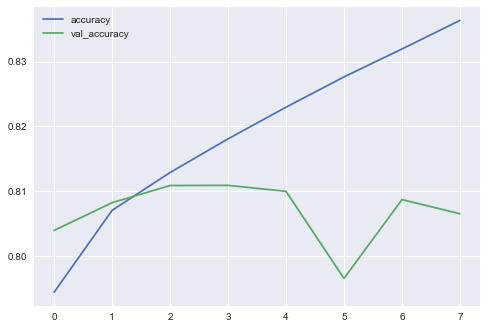

In [36]:
metrics_bert[['accuracy','val_accuracy']].plot()
plt.savefig('../figures/bert_50_acc.jpg', dpi=300)

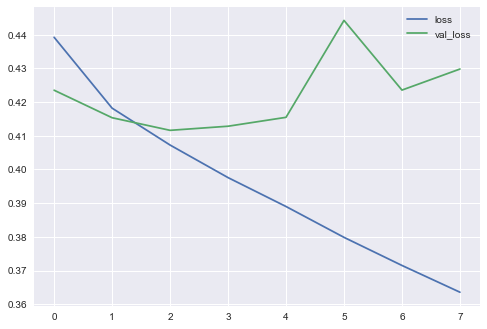

In [37]:
metrics_bert[['loss','val_loss']].plot()
plt.savefig('../figures/bert_50_loss.jpg', dpi=300)

In [38]:
# Loss metrics for the trained model
test_loss, test_accuracy, test_precision, test_recall = bert_model.evaluate([test_input_ids, test_input_masks, test_segment_ids], test_labels)

160000/160000 [==============================] - 2273s 14ms/step


In [39]:
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')
print(f'Test precision: {test_precision}')
print(f'Test recall: {test_recall}')

Test loss: 0.4180451255053282
Test accuracy: 0.8070187568664551
Test precision: 0.8020179867744446
Test recall: 0.812767744064331


In [40]:
bert_model.save('../models/bert_model_50.h5')